In [391]:
from matplotlib import pyplot as plt
import numpy as np
import mido as md
import os
import pandas as pd
import statistics as st
from datetime import datetime
from numpy import mean
from scipy.stats import mode
from collections import Counter



## Preprocessing of the data

In [392]:
def midiTrackToNoteSequence(track, timeSignature, mid):
    sequence = []
    notes = {}
    prevTime = 0.0
    for msg in track:
        if msg.is_meta:
            if msg.type == "time_signature":
                timeSignature["numerator"] = msg.numerator
                timeSignature["denominator"] = msg.denominator
            elif msg.type == "set_tempo":
                usPerQuarter = msg.tempo
                sPerQuarter = usPerQuarter / 1e6
                timeSignature["tempo"] = 60 / sPerQuarter * \
                    timeSignature["denominator"] /4
        else:
            time = msg.time / mid.ticks_per_beat * \
                60 / timeSignature["tempo"] + \
                prevTime
            
            if msg.type == "note_on" or msg.type =="note_off":

                note = {
                    "channel": msg.channel,
                    "note": msg.note,
                    "velocity": msg.velocity,
                    "time": time,
                    "end": -1
                }
                key = "{:02}_{:03}".format(msg.channel, msg.note)

                if msg.type == "note_on":
                    if not key in notes:
                        notes[key] = []
                    else: 
                        prevNote = notes[key][-1]

                        if prevNote["end"] < 0:
                            prevNote["end"] = time

                    notes[key].append(note)
                else:
                    if key in notes:
                        prevNote = notes[key][-1]

                        prevNote["end"] = time

            prevTime = time

    for key in notes.keys():
        for note in notes[key]:
            noteLength = 1.0

            if note["end"] >= 0.0:
                noteLength = note["end"] - note["time"]

            sequence.append({
                "time": note["time"],
                "number": note["note"],
                "length": noteLength
            })

    sequence.sort(key = lambda note: note["time"])

    return sequence

def findTrackName(track):
    for msg in track:
        if msg.type == "track_name":
            return msg.name
    return None

def printTrackNames(midiFilename):
    mid = md.MidiFile(midiFilename)

    print("Tracks in {}:".format(midiFilename))

    for track in mid.tracks:
        print("\t{}".format(findTrackName(track)))

def readMidiFileIntoPointSet(filename, trackName = None, singleNote = False):
    mid = md.MidiFile(filename)

    timeSignature = {
        "numerator": 4,
        "denominator": 4,
        "tempo": 60
    }

    noteTimes = []
    noteNumbers = []
    noteLengths = []

    sequence = []

    for track in mid.tracks:
        if trackName:
            currentName = findTrackName(track)

            if currentName != trackName:
                continue

        sequence.extend(midiTrackToNoteSequence(track, timeSignature, mid))

    sequence.sort(key = lambda note: note["time"])

    SMALL_DT = 0.01

    for note in sequence:
        if singleNote and len(noteTimes) > 0:
            if note["time"] - noteTimes[-1] < SMALL_DT:
                continue

        
        noteTimes.append(note["time"])
        noteNumbers.append(note["number"])
        noteLengths.append(note["length"])

    return {
        "t": np.array(noteTimes),
        "n": np.array(noteNumbers),
        "l": np.array(noteLengths),
        "timeSignature": timeSignature
    }

def get_midi_duration(midi_data):
    return midi_data["t"][-1]  #Assuming the last time value represents the total duration

def segment_midi(midi_data, segment_length):
    segments = []
    start_time = 0
    while start_time < midi_data["t"][-1]:
        end_time = start_time + segment_length
        segment_indices = np.where((midi_data["t"] >= start_time) & (midi_data["t"] < end_time))
        segment = {
            "t": midi_data["t"][segment_indices] - start_time,
            "n": midi_data["n"][segment_indices],
            "l": midi_data["l"][segment_indices],
            "timeSignature": midi_data["timeSignature"]
        }
        segments.append(segment)
        start_time += segment_length
    return segments


## Save results

In [393]:
def save_to_excel(key_A_values, PTD_values, normalised_PTD):
    #Saves the results to an Excel file
    results_folder = "results"
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{results_folder}/PTD_results_{current_time_str}.xlsx"

    df = pd.DataFrame({
        "Key_A": key_A_values,
        "PTD": PTD_values,
        "Normalised PTD": normalised_PTD,
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })
    
    df.to_excel(filename, index=False)


## Normalisation of score

In [394]:
def consistent_normalize_score(score, scale_max=10000):
    #Ensure the estimated maximum score is not zero to avoid division by zero
    if scale_max == 0:
        return 0  # Optionally adjust based on your context
    #Normalize the score
    normalized_score = (score / scale_max) * 100
    #Ensure the normalized score does not exceed 100
    normalized_score = min(normalized_score, 100)
    normalized_score = max(normalized_score, 0)
    
    return normalized_score

## Algorithm development and experimentation

In [395]:
def proportionalTransportationDistance(set_A, set_B):
    w = set_A["l"] #note weights
    u = set_B["l"]

    W = w.sum()
    U = u.sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w/W).sum()
    p2 = set_B["n"] - (set_B["n"] * u/U).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)/U
    d = np.sqrt(
        9 * (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )
    return (f*d).sum() / W

def modifiedPTD(set_A, set_B):
    w = set_A["l"] / set_A["l"].sum()
    u = set_B["l"] / set_B["l"].sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w).sum()
    p2 = set_B["n"] - (set_B["n"] * u).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)
    d = np.sqrt(
        (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )

    dargmin0 = d.argmin(axis=0)
    dargmin1 = d.argmin(axis=1)

    dmin0 = d[dargmin0, :]
    dmin1 = d[:, dargmin1]
    fmin0 = f[dargmin0, :]
    fmin1 = f[:, dargmin1]

    return (fmin0 * dmin0).sum() + (fmin1 * dmin1).sum()

#Function to safely normalize time to avoid division by zero
def safe_normalize_time(t):
    if t.size == 0:  #Check if the array is empty
        return t  #Return the empty array directly 
    min_t = t.min()
    max_t = t.max()
    if min_t == max_t:
        return np.zeros_like(t)
    else:
        return (t - min_t) / (max_t - min_t)

#modifiedPTDv1 function with safe normalization
def modifiedPTDv1(set_A, set_B):
    #safe_normalize_time function for time normalization to prevent div by 0 error
    t1 = safe_normalize_time(set_A["t"])
    t2 = safe_normalize_time(set_B["t"])
    
    p1 = set_A["n"] #pitch
    p2 = set_B["n"]

    #length normalization
    l1 = set_A["l"] / np.max(set_A["l"])  #Normalize lengths in set_A
    l2 = set_B["l"] / np.max(set_B["l"])  #Normalize lengths in set_B

    d_base = np.sqrt((t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 + (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2)
    
    d_length = np.abs(l1.reshape(-1, 1) - l2.reshape(1, -1)) #note lengths 
    d_combined = d_base + d_length
    total_distance = np.min(d_combined, axis=0).sum() + np.min(d_combined, axis=1).sum()

    return total_distance



def find_transposition_factor(pitch_sequence_a, pitch_sequence_b):
    # Ensure pitch sequences have the same length
    min_length = min(len(pitch_sequence_a), len(pitch_sequence_b))
    pitch_sequence_a = pitch_sequence_a[:min_length]
    pitch_sequence_b = pitch_sequence_b[:min_length]

    # Calculate pitch differences between sequences
    pitch_differences = pitch_sequence_b - pitch_sequence_a

    # Convert pitch differences to a NumPy array
    pitch_differences = np.array(pitch_differences)

    # Find the mode of pitch differences
    mode_info = st.mode(pitch_differences)
    
    # Extract the mode value from the result
    mode_factor = mode_info.item()

    # Calculate the percentage of occurrences of the mode
    mode_occurrences = np.count_nonzero(pitch_differences == mode_factor)
    total_occurrences = len(pitch_differences)
    mode_percentage = mode_occurrences / total_occurrences

    # Check if the mode occurs more than 60% of the time
    if mode_percentage < 0.9:
        mode_factor = 0
    

    return mode_factor

def normalize_pitch_sequence(pitch_sequence, transposition_factor):
    # Normalize pitch sequence by adding transposition factor
    normalized_pitch_sequence = pitch_sequence + transposition_factor
    
    return normalized_pitch_sequence

def modifiedPTDv2(set_A, set_B, transposition_factor):

    #transposition_factor=0
    
    # Normalize pitch sequences of set B using transposition factor
    normalized_pitch_sequence_B = normalize_pitch_sequence(set_B["n"], transposition_factor)
    
    # Safe normalize time
    t1 = safe_normalize_time(set_A["t"])
    t2 = safe_normalize_time(set_B["t"])
    
    p1 = set_A["n"]  # Original pitch sequence A
    p2 = normalized_pitch_sequence_B  # Normalized pitch sequence B
    
    # Length normalization
    l1 = set_A["l"] / np.max(set_A["l"])
    l2 = set_B["l"] / np.max(set_B["l"])
    
    # Calculate base distance
    d_base = np.sqrt((t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 + (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2)
    
    # Calculate length distance
    d_length = np.abs(l1.reshape(-1, 1) - l2.reshape(1, -1))
    
    # Combine distances
    d_combined = d_base + d_length
    
    # Calculate total distance
    total_distance = np.min(d_combined, axis=0).sum() + np.min(d_combined, axis=1).sum()

    return total_distance


## Calculating scores and displaying of results

PTD(appass_1.mid, SubMidi) = 0.0 at: 0 transposition
PTD(appass_3.mid, SubMidi) = 629.919031221218 at: 0 transposition
PTD(chpn_op35_1.mid, SubMidi) = 771.8202712566389 at: 0 transposition
PTD(beethoven_hammerklavier_4.mid, SubMidi) = 847.5262393094175 at: 0 transposition
PTD(chpn_op53.mid, SubMidi) = 873.3470746276901 at: 0 transposition
PTD(chpn_op10_e12.mid, SubMidi) = 887.1122681527374 at: 0 transposition
PTD(brahms_opus1_3.mid, SubMidi) = 929.1092623033851 at: 0 transposition
PTD(liz_et_trans4.mid, SubMidi) = 981.252367502441 at: 0 transposition
PTD(beethoven_hammerklavier_1.mid, SubMidi) = 1025.221294408434 at: 0 transposition
PTD(beethoven_les_adieux_3.mid, SubMidi) = 1029.0741603567228 at: 0 transposition
PTD(brahms_opus1_1.mid, SubMidi) = 1029.987085045503 at: 0 transposition
PTD(muss_8.mid, SubMidi) = 1082.3802288298402 at: 0 transposition
PTD(liz_et6.mid, SubMidi) = 1123.2561764317225 at: 0 transposition
PTD(chpn_op23.mid, SubMidi) = 1124.0146306277647 at: 0 transposition
PT

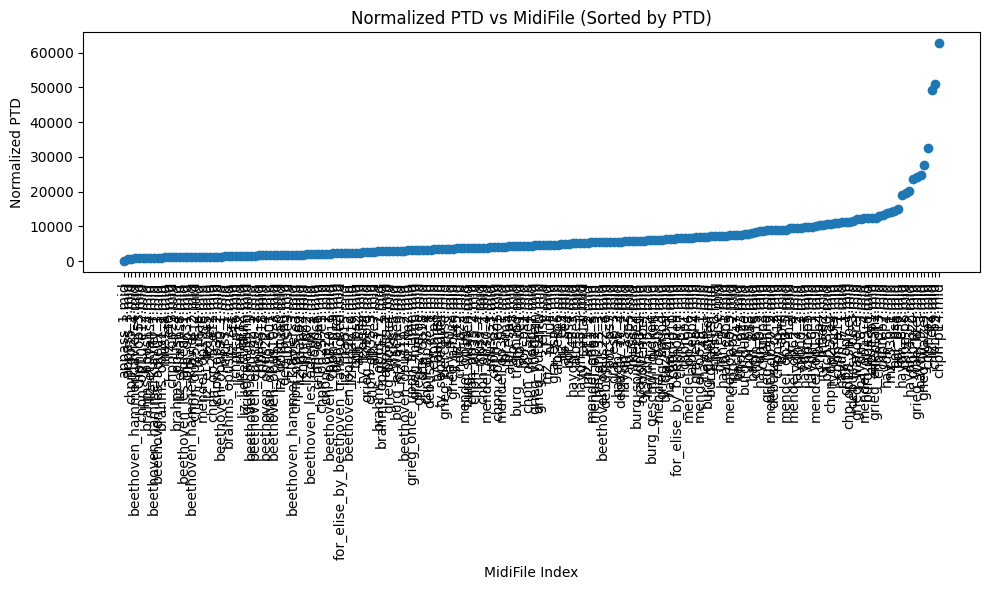

Minimum Score: appass_1.mid: 0.0


In [396]:

subMidi_folder_path = "SubjectMidiFile"
folder_path = "MIDITestDb"
subMidi_name = "SubMidi"
sets = {}


#Define the get_midi_duration function
def get_midi_duration(midi_data):
    return midi_data["t"][-1]

#Define the segment_midi function
def segment_midi(midi_data, segment_length):
    segments = []
    start_time = 0
    while start_time < midi_data["t"][-1]:
        end_time = start_time + segment_length
        segment_indices = np.where((midi_data["t"] >= start_time) & (midi_data["t"] < end_time))[0]
        segment = {
            "t": midi_data["t"][segment_indices] - start_time,
            "n": midi_data["n"][segment_indices],
            "l": midi_data["l"][segment_indices],
            "timeSignature": midi_data["timeSignature"]
        }
        segments.append(segment)
        start_time += segment_length
    return segments

#Load the subject MIDI file
for sub_file_name in os.listdir(subMidi_folder_path):
    if sub_file_name.endswith((".mid", ".midi")):
        file_path = os.path.join(subMidi_folder_path, sub_file_name)
        SubjectMidi = readMidiFileIntoPointSet(file_path)
        subject_midi_data = SubjectMidi
        sets[subMidi_name] = SubjectMidi
        break  #Process only the first MIDI file as the subject MIDI

subject_duration = get_midi_duration(subject_midi_data)

#Process and compare MIDI files in the dataset folder
for file_name in os.listdir(folder_path):
    if file_name.endswith((".mid", ".midi")):
        file_path = os.path.join(folder_path, file_name)
        midi_data = readMidiFileIntoPointSet(file_path)
        sets[file_name] = midi_data

min_score = float('inf')
second_min_score = float('inf')
min_score_file = ""
second_min_score_file = ""

key_A_values = []
PTD_values = []
Normalized_PTD_values = []
Transposition_fac_values = []


#Compare each MIDI file to the subject MIDI file
for key_A, midi_data_A in sets.items():
    if key_A == subMidi_name:
        continue  #Skip comparing the subject MIDI file to itself

    transposition_factors = []#array for the transposition factors for each segment

    midi_duration_A = get_midi_duration(midi_data_A)
    if midi_duration_A > subject_duration:
        segments = segment_midi(midi_data_A, subject_duration)

        for segment in segments:
            transposition_factor = find_transposition_factor(subject_midi_data["n"], segment["n"])
            transposition_factors.append(transposition_factor)

        t_factor_segments = st.mode(transposition_factors)     
        # Calculate the percentage of occurrences of the mode
        mode_occurrences = np.count_nonzero(np.array(transposition_factors) == t_factor_segments)
        total_occurrences = len(transposition_factors)
        mode_percentage = mode_occurrences / total_occurrences

        # Check if the mode occurs more than 50% of the time
        if mode_percentage < 0.9:
            t_factor_segments = 0

        distances = [modifiedPTDv2(segment, subject_midi_data, t_factor_segments) for segment in segments]
        
        # distances = [modifiedPTDv1(segment, subject_midi_data) for segment in segments]

        PTD = min(distances) #set PTD to smallest score

    else:
        transposition_factor = find_transposition_factor(subject_midi_data["n"], midi_data_A["n"])
        PTD = modifiedPTDv2(midi_data_A, subject_midi_data, transposition_factor)
        # PTD = modifiedPTDv1(midi_data_A, subject_midi_data)


    # print("PTD({}, {}) = {}".format(key_A, subMidi_name, PTD))

    if PTD < min_score:
        second_min_score, min_score = min_score, PTD
        second_min_score_file, min_score_file = min_score_file, key_A
    elif PTD < second_min_score:
        second_min_score = PTD
        second_min_score_file = key_A

    Normalized_PTD = PTD  #Placeholder for normalization logic
    Normalized_PTD_values.append(Normalized_PTD)
    key_A_values.append(key_A)
    PTD_values.append(PTD)
    Transposition_fac_values.append(transposition_factor)

    #save results to an Excel file
    save_to_excel(key_A_values, PTD_values, Normalized_PTD_values)

#Plot the results
plotData = list(zip(key_A_values, Normalized_PTD_values, Transposition_fac_values))
sorted_data = sorted(plotData, key=lambda x: x[1])
sorted_key_A_values, sorted_PTD_values,  sorted_transposition_fac_values,= zip(*sorted_data)

for key_A, PTD_value, transposition_factor in sorted_data:
    print("PTD({}, {}) = {} at: {} transposition".format(key_A, subMidi_name, PTD_value, transposition_factor)) #print PTD results in ascending order
print("________________________________________________________________________")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(range(len(sorted_key_A_values)), sorted_PTD_values)
ax.set_xlabel('MidiFile Index')
ax.set_ylabel('Normalized PTD')
ax.set_title('Normalized PTD vs MidiFile (Sorted by PTD)')
ax.set_xticks(range(len(sorted_key_A_values)))
ax.set_xticklabels(sorted_key_A_values, rotation=90, ha='center')
plt.tight_layout()
plt.show()

print("Minimum Score: {}: {}".format(min_score_file, min_score))
# print("2nd Minimum Score: {}: {}".format(second_min_score_file, second_min_score))
